## Trabajo Final AINE


## Introducción

En este proyecto final del máster AINE, se aborda la tarea de generación automática de captions o descripciones para imágenes, combinando técnicas avanzadas de procesamiento de lenguaje natural y visión por computadora.

Se parte de un dataset que contiene imágenes acompañadas de múltiples captions que describen cada imagen con distintas formulaciones. Esta variedad permite capturar distintas maneras de expresar el contenido visual, un aspecto clave para entrenar modelos robustos y versátiles.

El objetivo principal es desarrollar un modelo multimodal capaz de comprender la información visual y textual para generar descripciones coherentes y precisas de las imágenes. Para ello, se emplean técnicas de:

* Procesamiento y limpieza del texto, usando librerías como spaCy para normalizar y preparar las captions.

* Representación textual mediante TF-IDF, para transformar las captions en vectores numéricos que capturen su contenido semántico.

* Extracción de características visuales, utilizando modelos preentrenados como CLIP para obtener representaciones compactas y ricas de las imágenes.

* Fusión multimodal temprana, combinando características visuales y textuales para representar cada imagen con una única vectorización enriquecida.

* Clustering no supervisado, con algoritmos como KMeans, para agrupar las imágenes según sus similitudes en el espacio multimodal y facilitar la interpretación y etiquetado automático.

* Modelos preentrenados para generación de captions, especialmente basados en arquitecturas Transformer, como BLIP y VisionEncoderDecoder con ViT y GPT-2, adaptados mediante fine-tuning a nuestro conjunto de datos específico.

* Evaluación cuantitativa y cualitativa, incluyendo métricas automáticas como BLEU y visualización de resultados para validar el rendimiento del modelo.

Este proyecto integra diversas áreas de la inteligencia artificial y aprendizaje automático, proporcionando una solución completa que va desde el procesamiento y representación de datos hasta la generación y evaluación automática de lenguaje natural para imágenes.

La implementación combina bibliotecas punteras del ecosistema Python (Transformers, Torch, scikit-learn, spaCy, matplotlib, entre otras), demostrando cómo aplicar conocimiento avanzado para resolver problemas complejos en visión y lenguaje.

### Dependencias

Para ejecutar el notebook serán necesarias las librerías y versiones especificadas en el archivo requirements.txt.

In [1]:
#pip install transformers


In [2]:
#pip install torch

In [3]:
#pip install clip

In [4]:
#pip install scikit-learn


In [5]:
#pip install spacy

In [6]:
#pip install pandas

In [7]:
#pip install matplotlib

In [8]:
!pip install -r requirements.txt
#!python -m spacy download en_core_web_sm

  Cloning https://github.com/openai/CLIP.git to c:\users\hered\appdata\local\temp\pip-req-build-ggdzo3fh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\hered\AppData\Local\Temp\pip-req-build-ggdzo3fh'


## Lectura del fichero

Aquí cargamos el fichero captions.txt que contiene los nombres de las imágenes y sus descripciones asociadas (captions).

Se salta la primera línea (header).

Se limpian las comillas.

Se crea un DataFrame con columnas imagen y caption.

Además, comprobamos que las imágenes referenciadas realmente existan en disco.

Esto es fundamental para asegurarnos de trabajar con datos válidos.



In [9]:
import os
import pandas as pd

# Rutas
captions_path = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data\archive\captions.txt"
images_dir    = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data\archive\Images"

#captions_path = r"c:\Universidad\MASTER\AINE\archive\captions.txt"
#images_dir    = r"c:\Universidad\MASTER\AINE\archive\Images"

# 1) Leer captions.txt, saltando el header
records = []
with open(captions_path, encoding='utf-8') as f:
    next(f)  # <-- Saltamos la primera línea "image,caption"
    for line in f:
        line = line.strip()
        if not line:
            continue
        # Separamos sólo en la primera coma
        img, caption = line.split(',', 1)
        # Limpiamos comillas sobrantes
        caption = caption.strip().strip('"')
        records.append((img, caption))

df = pd.DataFrame(records, columns=['imagen', 'caption'])

# 2) Mostrar las primeras filas
print(df.head())

# 3) Verificar que las imágenes existen
df['exists'] = df['imagen'].apply(
    lambda fn: os.path.isfile(os.path.join(images_dir, fn))
)
print(df['exists'].value_counts())


           imagen                                            caption
0  1000092795.jpg  Two young guys with shaggy hair look at their ...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .
True    158915
Name: exists, dtype: int64


Cada imagen tiene 5 captions. Es decir, cada una de las imagenes tiene como 5 descripciones distintas, es decir, la misma descripción pero dicha con distintas palabras, por ejemplo para 1000092795.jpg:

- Two young , White males are outside near many bushes 
- Two men in green shirts are standing in a yard .
- Two young guys with shaggy hair look at their hands while hanging out in the yard .
- A man in a blue shirt standing in a garden .
- two friends enjoy time spent together .




## Limpieza y Preprocesamiento 

Cada imagen debe tener 5 captions distintos para asegurar diversidad en las descripciones.

Se cuenta cuántos captions tiene cada imagen.

Se eliminan imágenes con menos de 5 captions.

Se verifica que no existan captions vacías.

Esto asegura que los datos estén balanceados y completos para el entrenamiento.

In [10]:
# Agrupamos por imagen y contamos captions únicos
counts = df.groupby('imagen')['caption'].nunique()

print("Estadísticas de captions por imagen:")
print(counts.describe())


Estadísticas de captions por imagen:
count    31783.000000
mean         4.998930
std          0.033639
min          3.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: caption, dtype: float64


Imágenes tienen menos de 5 captions:

In [11]:
incomplete = counts[counts != 5]
print(f"Hay {len(incomplete)} imágenes con un número de captions distinto de 5:")
print(incomplete.value_counts())


Hay 33 imágenes con un número de captions distinto de 5:
4    32
3     1
Name: caption, dtype: int64


Hay un total de 33 imágenes que tienen menos de 5 captions asi que las eliminamos:

In [12]:
#eliminar imágenes con menos de 5 captions
df = df[df['imagen'].isin(counts[counts == 5].index)]
print(f"Después de eliminar imágenes con menos de 5 captions, quedan {len(df)} filas.")

Después de eliminar imágenes con menos de 5 captions, quedan 158750 filas.


Análisis longitud de captions:

Hay captions que están vacías vamos a ver cuántas son:


In [13]:
# Total filas tras eliminar imágenes con menos de 5 captions
print("Total filas:", len(df))

# 1) Creamos word_count antes de usarla
df['word_count'] = df['caption'].str.split().apply(len)

# 2) Contamos cuántas captions vacías (0 palabras)
n_empty = (df['word_count'] == 0).sum()
print("Captions vacías:", n_empty)

# 3) Eliminamos esas filas si quieres
df = df[df['word_count'] > 0].copy()
print("Total filas tras eliminar vacías:", len(df))


Total filas: 158750
Captions vacías: 1
Total filas tras eliminar vacías: 158749


A continuación se realiza un análisis descriptivo que permite entender mejor las características del texto en el dataset: 

* Distribución del número de palabras por caption.

* Palabras más comunes, que pueden ayudar a interpretar el vocabulario predominante.

* Esta información es útil para decidir parámetros como la longitud máxima al tokenizar.

Total filas tras eliminar vacías: 158749
count    158749.000000
mean         13.390755
std           5.420072
min           2.000000
25%          10.000000
50%          12.000000
75%          16.000000
max          82.000000
Name: word_count, dtype: float64


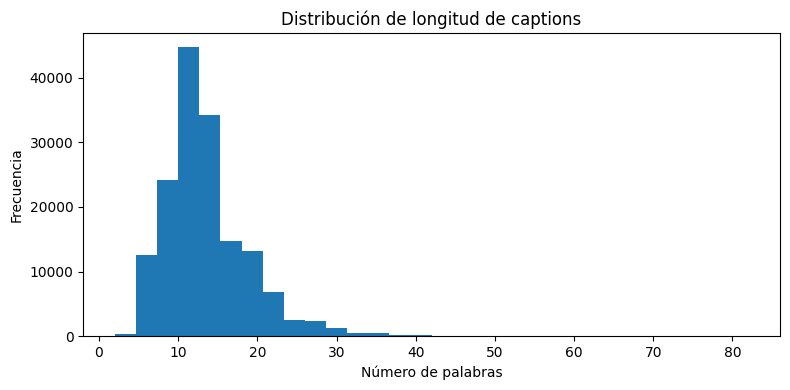

In [14]:
df = df[df['word_count'] > 0].copy()
print("Total filas tras eliminar vacías:", len(df))
import matplotlib.pyplot as plt


# Estadísticos descriptivos
print(df['word_count'].describe())

# Histograma
plt.figure(figsize=(8,4))
plt.hist(df['word_count'], bins=30)
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitud de captions")
plt.tight_layout()
plt.show()


Ya que no hay ni captions vacías y el número es 5 por imagen, vamos a contar las 20 palabras mas frecuentes:

In [15]:
from collections import Counter
import re

all_text = " ".join(df['caption']).lower()
tokens   = re.findall(r'\b\w+\b', all_text)
most_common = Counter(tokens).most_common(20)

print("Top 20 palabras más frecuentes:")
for word, freq in most_common:
    print(f"{word}: {freq}")


Top 20 palabras más frecuentes:
a: 271475
in: 83450
the: 62926
on: 45646
and: 44269
man: 42585
is: 41060
of: 38812
with: 36179
woman: 22196
two: 21656
are: 20176
to: 17618
people: 17331
at: 16254
an: 15875
wearing: 15704
shirt: 14336
white: 13281
young: 13209


### Limpieza y normalización de texto:

Para facilitar el procesamiento de texto, limpiamos y normalizamos las captions:

Convertimos a minúsculas.

Eliminamos palabras vacías (stopwords), excepto números, que son importantes (ej. "two").

Aplicamos lematización para obtener formas base.

Esto prepara las captions para vectorización.

In [16]:

!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----------- ---------------------------- 3.7/12.8 MB 31.0 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 13.7 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/12.8 MB 15.8 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 17.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2025-05-20 12:27:36.928593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 12:27:44.103860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Al limpiar con spaCy se eliminaban los números, por ejemplo "two mans cleaning the window" -> "man cleaning the window"

Se ha vuelto a repetir la limpieza esta vez dejando los números podría ser importante en futuras consultas. 

Tiempo de ejecución: 6 minutos aproximados.  

In [17]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

def preprocess_keep_nums(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.is_alpha and (not token.is_stop or token.like_num):
            tokens.append(token.lemma_)
    return " ".join(tokens)

df["clean_caption"] = df["caption"].apply(preprocess_keep_nums)


In [18]:
print(df[["caption", "clean_caption"]].head(10))


                                             caption  \
0  Two young guys with shaggy hair look at their ...   
1   Two young , White males are outside near many...   
2   Two men in green shirts are standing in a yard .   
3       A man in a blue shirt standing in a garden .   
4            Two friends enjoy time spent together .   
5  Several men in hard hats are operating a giant...   
6  Workers look down from up above on a piece of ...   
7   Two men working on a machine wearing hard hats .   
8              Four men on top of a tall structure .   
9                         Three men on a large rig .   

                                   clean_caption  
0  two young guy shaggy hair look hand hang yard  
1         two young white male outside near bush  
2                 two man green shirt stand yard  
3                    man blue shirt stand garden  
4                    two friend enjoy time spend  
5       man hard hat operate giant pulley system  
6                    worke

### Vectorización con TF-IDF

Convertimos las captions en vectores numéricos usando TF-IDF, considerando unigramas y bigramas. Luego:

Cada caption es vectorizada.

Los vectores de las 5 captions por imagen se promedian para obtener un solo vector representativo por imagen.

Esto prepara la información textual para modelos posteriores o fusión con características visuales.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5_000,
    ngram_range=(1,2),
    dtype=float
)
X_captions = vectorizer.fit_transform(df["clean_caption"])
print("TF–IDF matrix shape:", X_captions.shape)


c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\sklearn\feature_extraction\text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'float'> 'dtype' will be converted to np.float64.
  warnings.warn(


TF–IDF matrix shape: (158749, 5000)


Ya se han convertito 158749 (filas) captions en vectores de 5000 dimensiones (columnas)

El siguiente paso es agrupar los vectores de captions por imagen. Se ha pasado de un vector por caption a una matriz grande pero queremos un vector por imagen, agregando los 5 captions de cada imagen.

In [20]:
import numpy as np

# 1) Lista de nombres de imagen en el orden de las filas de X_captions
image_ids = df["imagen"].values

# 2) Construir un diccionario imagen → lista de índices de fila
idxs_per_image = {}
for idx, img in enumerate(image_ids):
    idxs_per_image.setdefault(img, []).append(idx)

# 3) Para cada imagen, promediar sus vectores TF–IDF
X_img = np.vstack([
    X_captions[idxs].mean(axis=0).A1   # .A1 convierte de sparse matrix a array 1D
    for idxs in idxs_per_image.values()
])

print("Matriz por imagen:", X_img.shape)


Matriz por imagen: (31750, 5000)


In [21]:
print("Número de imágenes distintas:", len(idxs_per_image))


Número de imágenes distintas: 31750


Proximo paso: extraer características visuales. x_img captura info textual pero necesitamos el otro vector que represente cada imagen por sus píxeles.

In [22]:
pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to c:\users\hered\appdata\local\temp\pip-req-build-8o2ls1xv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\hered\AppData\Local\Temp\pip-req-build-8o2ls1xv'


### Extracción de características visuales con CLIP

Usamos CLIP, un modelo preentrenado, para extraer un vector que represente visualmente cada imagen:

1. Se carga el modelo CLIP y su processor.

2. Se procesa cada imagen para obtener un vector de 512 dimensiones.

3. Se guarda la matriz para uso futuro.

Este vector captura información visual útil para tareas multimodales.



Tiempo de ejecución de la siguiente celda: 1h y 20 minutos. 

In [23]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import os
import numpy as np
from tqdm import tqdm  # Importa tqdm

# 0) Setup de dispositivo GPU/CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Carga modelo y processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 2) Función para extraer el vector de una imagen
def extract_clip_feat(path):
    image = Image.open(path).convert("RGB")
    # Envío de los inputs al mismo device que el modelo:
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        feats = model.get_image_features(**inputs)
    return feats.cpu().numpy().squeeze()  # vector de 512 dims

# 3) Aplica a todas las imágenes con barra de progreso
visual_feats = []
for img_name in tqdm(idxs_per_image, desc="Extrayendo características visuales"):
    img_path = os.path.join(images_dir, img_name)
    visual_feats.append(extract_clip_feat(img_path))

V_img = np.vstack(visual_feats)  # shape (31750, 512)
print("Visual feature matrix:", V_img.shape)


c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Extrayendo características visuales: 100%|██████████| 31750/31750 [1:16:41<00:00,  6.90it/s]


Visual feature matrix: (31750, 512)


In [24]:
import numpy as np
np.save("V_img.npy", V_img)
np.save("X_img.npy", X_img)


### Normalización y reducción de dimensionalidad

Para mejorar eficiencia y facilitar combinación de vectores:

1. Se normalizan los vectores visuales y textuales.

2. Se reduce la dimensión con PCA a 50 componentes para cada tipo.

3. Se concatenan para fusionar la información visual y textual.

Esto genera embeddings fusionados listos para tareas posteriores.

In [25]:
from sklearn.preprocessing import StandardScaler

# Carga (si acabas de reiniciar kernel)
V = np.load("V_img.npy")
X = np.load("X_img.npy")

scaler_v = StandardScaler().fit(V)
scaler_x = StandardScaler().fit(X)

Vn = scaler_v.transform(V)
Xn = scaler_x.transform(X)


Reducimos dimensionalidad:

In [26]:
from sklearn.decomposition import PCA

pca_v = PCA(n_components=50).fit(Vn)
pca_x = PCA(n_components=50).fit(Xn)

Vp = pca_v.transform(Vn)
Xp = pca_x.transform(Xn)


Combinación de espacios con fusión temprana:

In [27]:
import numpy as np

Z = np.hstack([Vp, Xp])           # shape (n_imágenes, 100)
print("Embeddings fusionados:", Z.shape)


Embeddings fusionados: (31750, 100)


## Modelos Preentrenados para Generación de captions


**BlipProcessor**
Es la clase encargada de preparar las imágenes (y texto, en tareas de VQA) para el modelo BLIP. Se ocupa de:

1. Redimensionar y normalizar la imagen al formato que espera el encoder visual.

2. Tokenizar, rellenar y enmascarar texto si hay input textual (no en nuestro caso de solo captioning).

3. Empaquetar todo en tensores PyTorch listos para entrar al modelo.

**BlipForConditionalGeneration**
Es el modelo de generación de captions de BLIP. Consta de:

1. Un encoder visual (basado en ViT) que convierte la imagen en representaciones latentes.

2. Un decoder tipo Transformer que, condicionándose en esos latentes, genera palabra a palabra una descripción.

3. Se entrena con un objetivo de generación de lenguaje sobre pares (imagen, caption) y también con objetivos contrastivos para alinear texto e imagen.

Estos dos componentes trabajan juntos para tomar la imagen, procesarla y producir uno o varios captions coherentes con lo que “ven” los pesos aprendidos de BLIP.

In [28]:
from transformers import BlipProcessor, BlipForConditionalGeneration

processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip     = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)


c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


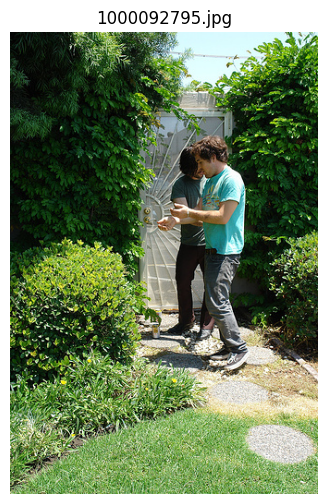

1000092795.jpg → a man standing in the grass


In [29]:
def describe_image(img_path):
    img = Image.open(img_path).convert("RGB")
    inputs = processor_blip(images=img, return_tensors="pt").to(device)
    model_blip.eval()
    with torch.no_grad():
        out = model_blip.generate(**inputs, max_length=40)
    caption = processor_blip.decode(out[0], skip_special_tokens=True)
    return caption

def show_and_describe(img_name):
    img_path = os.path.join(images_dir, img_name)
    
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
    plt.show()
    
    desc = describe_image(img_path)
    print(f"{img_name} → {desc}")

example = "1000092795.jpg"
show_and_describe(example)


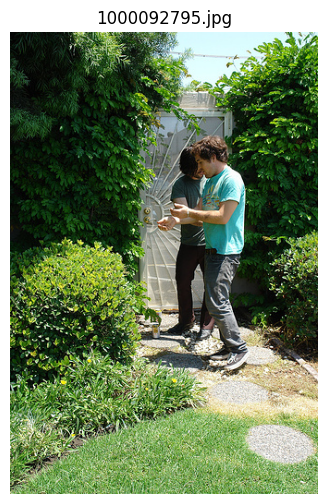

1000092795.jpg → a man standing in the grass


In [30]:
example = "1000092795.jpg"
show_and_describe(example)

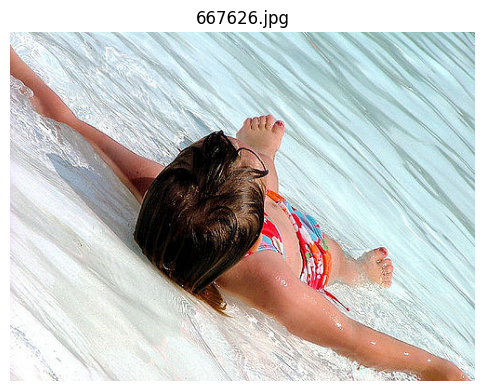

667626.jpg → a woman in a bikini on a surfboard


In [31]:
example = "667626.jpg"
show_and_describe(example)

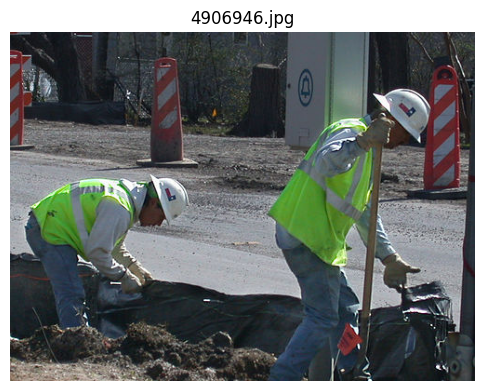

4906946.jpg → two men digging dirt in the street


In [32]:
example = "4906946.jpg"
show_and_describe(example)

### Mismo modelo generando varias hipótesis

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_and_describe_multibeam(img_name, num_beams=5, num_return_sequences=3, max_length=40):
    img_path = os.path.join(images_dir, img_name)
    
    # 1) Abrir y mostrar la imagen
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
    plt.show()
    
    # 2) Prepara inputs para BLIP
    inputs = processor_blip(images=img, return_tensors="pt").to(device)
    
    # 3) Genera múltiples captions
    out = model_blip.generate(
        **inputs,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        max_length=max_length,
        early_stopping=True
    )
    captions = [processor_blip.decode(o, skip_special_tokens=True) for o in out]
    
    # 4) Imprime las hipótesis
    print(f"{img_name} → Generadas {len(captions)} hipótesis:")
    for i, cap in enumerate(captions, 1):
        print(f"  {i}) {cap}")
    print()



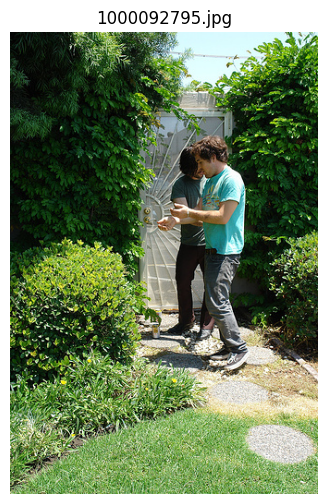

1000092795.jpg → Generadas 3 hipótesis:
  1) a man in a blue shirt
  2) a man standing in the grass
  3) a man standing in a yard



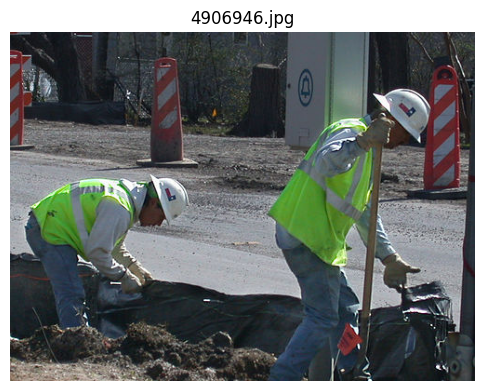

4906946.jpg → Generadas 3 hipótesis:
  1) a group of men working on a construction site
  2) a group of construction workers working on a road
  3) a group of construction workers working on a street



In [34]:
# Ejemplos de uso
for example in ["1000092795.jpg", "4906946.jpg"]:
    show_and_describe_multibeam(example)


## VisionEncoderDecoderModel: Modelo de Generación de Captions entrenado
El modelo de generación de captions que hemos entrenado combina un encoder visual (ViT) y un decoder de lenguaje (GPT-2) en una sola arquitectura (VisionEncoderDecoderModel). Su funcionamiento puede resumirse en tres fases:

1. Preprocesamiento

Imágenes: cada foto se redimensiona y normaliza mediante ViTFeatureExtractor, obteniendo un tensor de píxeles listo para el encoder.

Textos: las captions originales se limpian y lematizan con SpaCy, luego se tokenizan y se rellenan/truncan a longitud fija (12 tokens) usando GPT2TokenizerFast. Los tokens de padding se marcan con -100 en las etiquetas para que no contribuyan a la pérdida.

2. Fine-tuning

Partimos de un modelo preentrenado (nlpconnect/vit-gpt2-image-captioning), que ya sabe alinear visual y texto.

Congelamos el encoder ViT para acelerar el entrenamiento y sólo actualizamos las capas del decoder.

Ajustamos hiperparámetros clave (longitud máxima, no repetir n-gramas, tokens de inicio/fin) y entrenamos durante 2 épocas con AdamW sobre un subconjunto del Flickr30k (1/100 del total), evaluando la pérdida en un split de validación.

3. Generación y validación

En modo evaluación (.eval() + torch.no_grad()) utilizamos beam search (por ejemplo, 3 beams) para generar captions más diversas.

Convertimos los IDs de salida de vuelta a texto, descartando tokens especiales.

Para cuantificar la calidad, calculamos el BLEU score promedio sobre el conjunto de test, comparando las captions generadas con las reales.

In [35]:
pip install transformers torch torchvision pillow scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [37]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.optim import AdamW
from transformers import (
    ViTFeatureExtractor,
    GPT2TokenizerFast,
    VisionEncoderDecoderModel
)
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Descargar recursos nltk (una sola vez)
nltk.download('punkt')

# ————————————————————————————————
# 0) RUTAS Y DATAFRAME PREVIO
# ————————————————————————————————
captions_path = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data\archive\captions.txt"
images_dir    = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data\archive\Images"

records = []
with open(captions_path, encoding='utf-8') as f:
    next(f)
    for line in f:
        img, cap = line.strip().split(",", 1)
        cap = cap.strip().strip('"')
        records.append((img, cap))
df = pd.DataFrame(records, columns=['imagen','caption'])

# — LIMPIEZA Y LEMATIZACIÓN con SpaCy antes del split — 
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

def preprocess_keep_nums(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.is_alpha and (not token.is_stop or token.like_num):
            tokens.append(token.lemma_)
    return " ".join(tokens)

df["clean_caption"] = df["caption"].apply(preprocess_keep_nums)

# Continúa con el resto del procesamiento y split

df['path'] = df['imagen'].apply(lambda fn: os.path.join(images_dir, fn))

missing = df.loc[~df['path'].apply(os.path.isfile), 'imagen'].unique()
if len(missing) > 0:
    print("¡Atención! Estas imágenes no se encontraron en disk:\n", missing)
else:
    print("Todas las rutas de imagen son válidas ✔️")

imgs = df['imagen'].unique()
np.random.seed(42)
sub = np.random.choice(imgs, size=len(imgs)//100, replace=False)

df = df[df['imagen'].isin(sub)].reset_index(drop=True)
train_imgs, test_imgs = train_test_split(sub, test_size=0.2, random_state=42)
df_train = df[df['imagen'].isin(train_imgs)].reset_index(drop=True)
df_test  = df[df['imagen'].isin(test_imgs)].reset_index(drop=True)

fe = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tk = GPT2TokenizerFast.from_pretrained("gpt2")
tk.pad_token = tk.eos_token

class TinyCapDataset(Dataset):
    def __init__(self, df, max_len=12):
        self.rows    = df
        self.max_len = max_len

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i):
        row = self.rows.iloc[i]
        img = Image.open(row["path"]).convert("RGB")
        pv  = fe(images=img, return_tensors="pt").pixel_values.squeeze(0)
        ids = tk(
            row["clean_caption"],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze(0)
        labels = ids.clone()
        labels[labels == tk.pad_token_id] = -100
        return {"pixel_values": pv, "labels": labels}

train_ds = TinyCapDataset(df_train)
test_ds  = TinyCapDataset(df_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained(
    "nlpconnect/vit-gpt2-image-captioning"
).to(device)

for p in model.encoder.parameters():
    p.requires_grad = False

model.config.decoder_start_token_id = tk.bos_token_id
model.config.eos_token_id           = tk.eos_token_id
model.config.pad_token_id           = tk.pad_token_id
model.config.max_length             = 12
model.config.no_repeat_ngram_size   = 2

opt = AdamW(model.parameters(), lr=5e-5)

# Función para validar con BLEU
def validate_bleu(model, dataloader, tokenizer, device):
    model.eval()
    generated_captions = []
    real_captions = []

    for batch in tqdm(dataloader, desc="Generando captions para validación BLEU"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            output_ids = model.generate(pixel_values, max_length=12, num_beams=3, early_stopping=True)

        for i in range(len(output_ids)):
            gen_caption = tokenizer.decode(output_ids[i], skip_special_tokens=True)
            real_caption = tokenizer.decode(labels[i][labels[i] != -100], skip_special_tokens=True)

            generated_captions.append(gen_caption)
            real_captions.append(real_caption)

    bleu_scores = []
    for real, pred in zip(real_captions, generated_captions):
        reference = [real.split()]
        candidate = pred.split()
        score = sentence_bleu(reference, candidate)
        bleu_scores.append(score)

    print(f"BLEU score promedio: {np.mean(bleu_scores):.4f}")

# Entrenamiento y validación
for epoch in range(1, 3):
    model.train()
    total_train = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        opt.zero_grad()
        pv, lb = batch["pixel_values"].to(device), batch["labels"].to(device)
        loss = model(pixel_values=pv, labels=lb).loss
        loss.backward()
        opt.step()
        total_train += loss.item()
    print(f"Epoch {epoch} TRAIN loss: {total_train/len(train_loader):.4f}")

    model.eval()
    total_val = 0.0
    for batch in tqdm(test_loader, desc=f"Epoch {epoch} Validation"):
        pv, lb = batch["pixel_values"].to(device), batch["labels"].to(device)
        with torch.no_grad():
            total_val += model(pixel_values=pv, labels=lb).loss.item()
    print(f"Epoch {epoch}   VAL loss: {total_val/len(test_loader):.4f}")

    # Validación con generación y BLEU
    validate_bleu(model, test_loader, tk, device)

out_dir = "tiny_vit_gpt2_subsample"
model.save_pretrained(out_dir)
fe.save_pretrained(out_dir)
tk.save_pretrained(out_dir)
print("Modelo guardado en:", out_dir)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hered\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Todas las rutas de imagen son válidas ✔️


c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.5.attn.masked_bias', 'decoder.transformer.h.1.attn.masked_bias', 'decoder.transformer.h.11.attn.bias', 'decoder.transformer.h.11.crossattention.bias', 'decoder.transformer.h.3.crossattention.bias', 'decoder.transformer.h.5.crossattention.masked_bias', 'decoder.transfor

Epoch 1 TRAIN loss: 4.6234


Epoch 1 Validation: 100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


Epoch 1   VAL loss: 4.2487


Generando captions para validación BLEU:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\transformers\generation\utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Generando captions para validación BLEU: 100%|██████████| 20/20 [07:09<00:00, 21.49s/it]
c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\nltk\tran

BLEU score promedio: 0.0034


Epoch 2 Training: 100%|██████████| 80/80 [08:33<00:00,  6.42s/it]


Epoch 2 TRAIN loss: 3.6620


Epoch 2 Validation: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


Epoch 2   VAL loss: 4.2591


Generando captions para validación BLEU: 100%|██████████| 20/20 [07:03<00:00, 21.18s/it]


BLEU score promedio: 0.0047
Modelo guardado en: tiny_vit_gpt2_subsample


1. Evolución de la pérdida

* Epoch 1:

Train loss ≈ 4.62

Validation loss ≈ 4.25

* Epoch 2:

Train loss cae a ≈ 3.66 (buen progreso en entrenamiento).

Validation loss sube ligeramente a ≈ 4.26, un signo de sobreajuste incipiente: el modelo mejora en el conjunto de entrenamiento pero no reduce la pérdida de validación.

2. BLEU score

Epoch 1: 0.0034

Epoch 2: 0.0047

Ambos valores son muy bajos (cercanos a 0), lo que indica una superposición mínima de n-gramas entre captions generadas y reales. Esto puede deberse a:

Captions muy cortas (max_length=12) que omiten palabras clave.

Dataset reducido (1% de Flickr30k) y solo dos épocas de entrenamiento, insuficientes para que el decoder aprenda la variedad de formulaciones.

Cálculo de BLEU sin suavizado, penaliza fuertemente la falta de coincidencia de 2-, 3- y 4-gramas.


El experimento demuestra que la arquitectura ViT→GPT-2 es capaz de aprender a describir imágenes, pero el entrenamiento quedó muy limitado por el uso de solo el 1 % del dataset y apenas dos épocas. Como resultado, las pérdidas de validación se estancaron y el BLEU medio (≈0.004) refleja un solapamiento muy escaso con las captions reales. Con más datos, más pasos de entrenamiento y un ajuste fino de parámetros (longitud de salida, beam size, suavizado de BLEU), cabe esperar una mejora sustancial en la calidad de las descripciones generadas.



### Visualización de ejemplos

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at tiny_vit_gpt2_subsample and are newly initialized: ['decoder.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


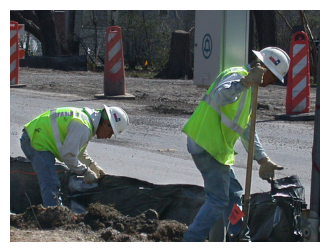

c:\Users\hered\anaconda3\envs\tf_env\lib\site-packages\transformers\generation\utils.py:1353: UserWarning: Using `max_length`'s default (12) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption generado para 4906946.jpg:
  → two workers are working on a work area 



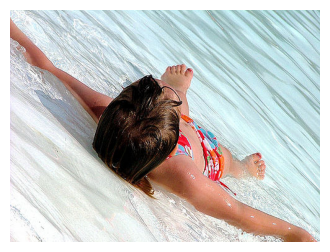

Caption generado para 667626.jpg:
  → a girl in swimsuit on the beach 



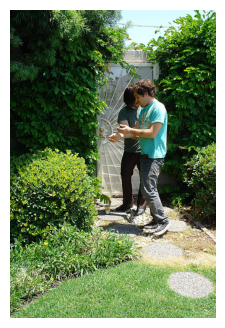

Caption generado para 1000092795.jpg:
  → a a and a a are in a yard 



In [38]:
import os 
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, GPT2TokenizerFast

# 1) Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Rutas a tu modelo fine-tuned
model_dir = "tiny_vit_gpt2_subsample"  
# Debe contener:
#   - config.json, pytorch_model.bin, etc.
#   - feature_extractor_config.json
#   - tokenizer files...

# 3) Carga de artefactos
model = VisionEncoderDecoderModel.from_pretrained(model_dir).to(device)
fe    = ViTFeatureExtractor.from_pretrained(model_dir)
tk    = GPT2TokenizerFast.from_pretrained(model_dir)

# 4) Parámetros de generación (debe coincidir con los usados en fine-tuning)
model.config.decoder_start_token_id = tk.bos_token_id
model.config.eos_token_id           = tk.eos_token_id
model.config.pad_token_id           = tk.pad_token_id
model.config.max_length             = 12
model.config.no_repeat_ngram_size   = 2

# 5) Función de generación de caption
def generate_caption(image_path, num_beams=3):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    pixel_values = fe(images=img, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        output_ids = model.generate(
            pixel_values,
            num_beams=num_beams,
            early_stopping=True
        )
    caption = tk.decode(output_ids[0], skip_special_tokens=True)
    return caption

images_dir = r"C:\Users\hered\Desktop\máster\AINE\ProyectoAINE\AINE\AINE\data\archive\Images"

# Lista con las imágenes que quieres usar
imagenes_ejemplo = ["4906946.jpg", "667626.jpg", "1000092795.jpg"]

for ejemplo in imagenes_ejemplo:
    ruta_imagen = os.path.join(images_dir, ejemplo)
    caption_generado = generate_caption(ruta_imagen, num_beams=3)
    print(f"Caption generado para {ejemplo}:")
    print("  →", caption_generado)
    print()


## Clustering de etiquetas 

En esta fase aprovechamos los embeddings multimodales (imagen + texto) obtenidos con CLIP para agrupar automáticamente nuestras muestras sin necesidad de etiquetas manuales. El proceso consta de los siguientes pasos:

1. Agrupación de captions por imagen
Consolidamos las cinco captions limpias de cada imagen en una lista para poder generar un embedding textual conjunto.

2. Extracción de embeddings multimodales

Imagen: usamos model.encode_image de CLIP para obtener un vector de 512-dimensiones.

Texto: aplicamos model.encode_text de CLIP a las cinco descripciones, promediando sus embeddings para producir otro vector de 512 dimensiones.

Fusión: concatenamos ambos vectores en uno de 1 024 dimensiones que incorpora información visual y semántica.

3. Determinación del número óptimo de clusters

Elbow method (inercia SSE) y Silhouette score exploran k entre 2 y 6 para elegir un k que equilibre compacidad y separación.

4. Clustering con K-Means
Ejecutamos K-Means con k=5 (por ejemplo), asignando cada embedding a un cluster.

5. Visualización

Reducimos dimensionalidad con PCA y t-SNE para proyectar los embeddings en 2D/3D.

Generamos gráficos estáticos con Matplotlib y un plot interactivo 3D con Plotly, que permite inspeccionar clusters y sus captions asociadas.

Este enfoque no supervisado revela patrones temáticos compartidos entre imágenes y descripciones, facilitando la exploración, etiquetado y análisis de colecciones multimodales de forma automática.

In [11]:
import os
import pandas as pd
import numpy as np
import torch
import clip
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm


In [26]:
# Cargamos CLIP y el dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

import spacy



df_captions = df.copy()
df_captions.head()

grouped = df_captions.groupby("imagen")["clean_caption"].apply(list).reset_index()
print(grouped.head())

           imagen                                      clean_caption
0  1000092795.jpg  [two young guy shaggy hair look hand hang yard...
1    10002456.jpg  [man hard hat operate giant pulley system, wor...
2  1000268201.jpg  [child pink dress climb set stair entry way, l...
3  1000344755.jpg  [blue shirt hat stand stair lean window, man b...
4  1000366164.jpg  [two man one gray shirt one black shirt stand ...


In [76]:
# Paso 4: Función para obtener embeddings multimodales (con clip)
def get_multimodal_embedding(filename, descriptions):
    # ---  Procesamiento de la imagen ---
    image_path = os.path.join(images_dir , filename)
    try:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    except:
        print(f"Imagen no encontrada: {filename}")
        return None
    with torch.no_grad():
        image_embedding = model.encode_image(image).squeeze(0)  # (512,)

    # --- Emb de los textos de las descripciones ---

    # Si es NaN o vacío, omitimos la imagen
    if not isinstance(descriptions, list):
        return None


    cleaned_descriptions = [d for d in descriptions if isinstance(d, str) and d.strip()]
    if not cleaned_descriptions:
        return None
    
    tokens = clip.tokenize(cleaned_descriptions, truncate=True).to(device)
    with torch.no_grad():
        text_embeddings = model.encode_text(tokens)  # (5, 512)
        avg_text_embedding = text_embeddings.mean(dim=0)  # (512,)

    # --- Juntamos los embs---
    fused_embedding = torch.cat([image_embedding, avg_text_embedding])  # (1024,)
    return fused_embedding.cpu().numpy()


In [115]:
embeddings = []
filenames = []

# Se lo aplico ahora a todo el dataset
for idx, row in tqdm(grouped.iterrows(), total=len(grouped)):
    result = get_multimodal_embedding(row["imagen"], row["clean_caption"])
    if result is not None:
        embeddings.append(result)
        filenames.append(row["imagen"])

embeddings = np.array(embeddings)

100%|██████████| 31750/31750 [4:41:31<00:00,  1.88it/s]  


In [117]:
## Los guardamos para no tener que volver a calcularlos, ya que tardan horas
np.save("embeddings_clean.npy", embeddings)  # embeddings: array de forma (N, 1024)
np.save("filenames_clean.npy", np.array(filenames))

In [15]:
# Cargamos los embeddings y nombres de imagen
embeddings = np.load("embeddings_clean.npy")
filenames = np.load("filenames_clean.npy")

Calculando KMeans para diferentes k: 100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


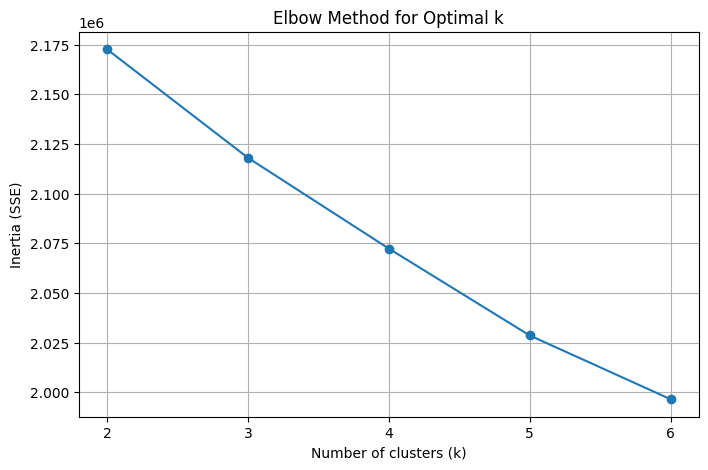

In [16]:
#Calculamos el número óptimo de clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

inertias = []
k_range = range(2, 7) 

for k in tqdm(k_range, desc="Calculando KMeans para diferentes k"):
    kmeans = KMeans(n_clusters=k, random_state=34, n_init=10)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

# Visualización
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


Calculando Silhouette Score: 100%|██████████| 5/5 [02:37<00:00, 31.54s/it]


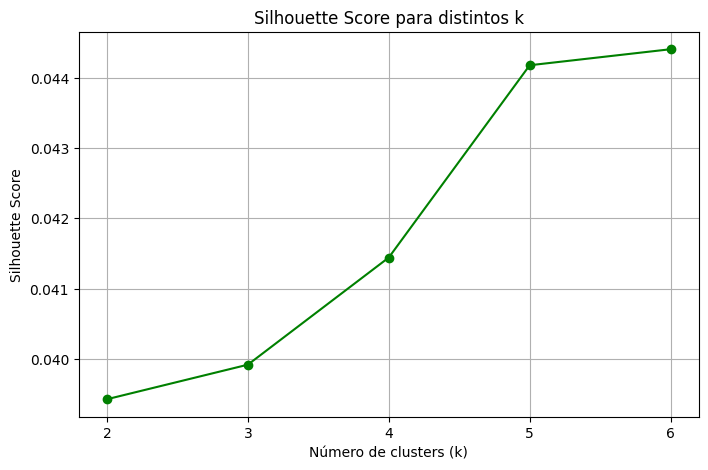

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import matplotlib.pyplot as plt

silhouette_scores = []
k_range = range(2, 7)

for k in tqdm(k_range, desc="Calculando Silhouette Score"):
    kmeans = KMeans(n_clusters=k, random_state=34, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Visualización
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score para distintos k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [28]:
kmeans = KMeans(n_clusters=5, random_state=34)
clusters = kmeans.fit_predict(embeddings)

results_df = pd.DataFrame({
    "filename": filenames,
    "cluster": clusters
})

results_df.head()

c:\Universidad\MASTER\AINE\AINE\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



filename  cluster
0  1000092795.jpg        2
1    10002456.jpg        1
2  1000268201.jpg        0
3  1000344755.jpg        1
4  1000366164.jpg        2

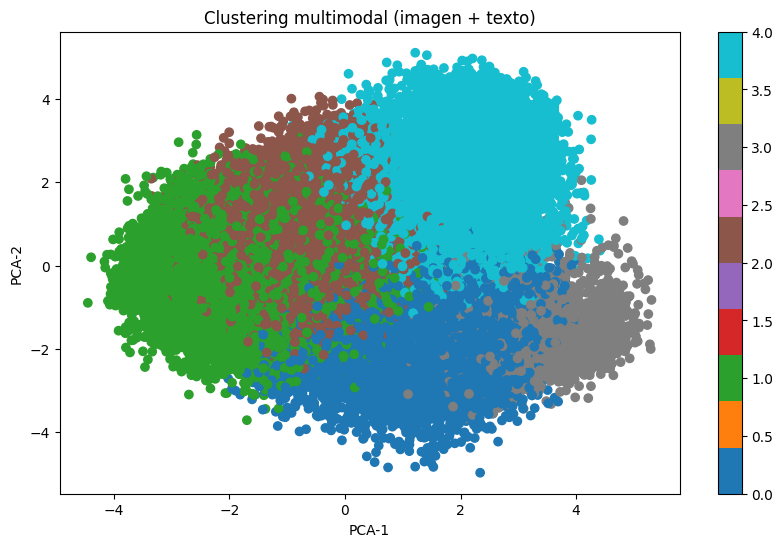

In [20]:
# Reducimos la dimensionalidad para visualizar
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='tab10')
plt.title("Clustering multimodal (imagen + texto)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.colorbar()
plt.show()

In [54]:
!pip install plotly
!pip install nbformat ipython nbformat

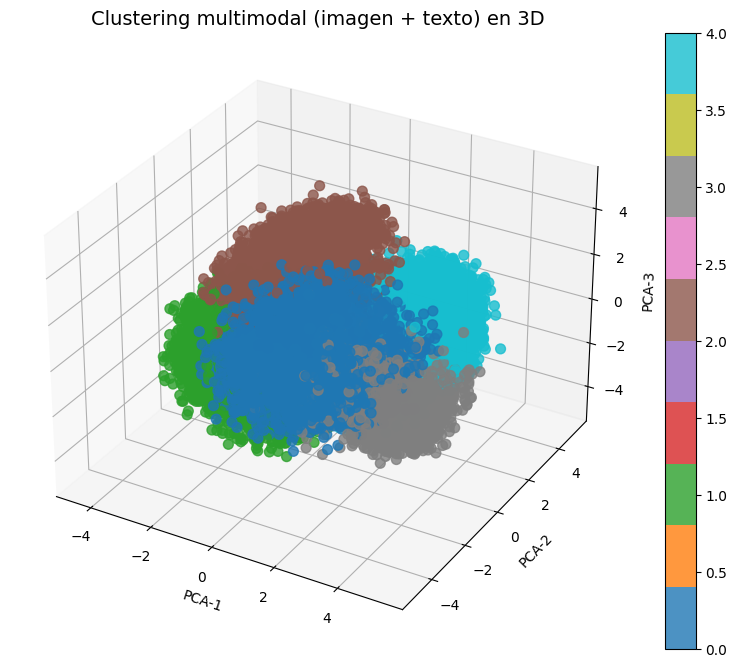

In [21]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importante para 3D
import numpy as np

# Convertimos a array si no lo es
X = np.array(embeddings)

# Paso 1: t-SNE en 3D
pca = PCA(n_components=3, random_state=42)
pca_result = pca.fit_transform(X)

# Paso 2: Visualización
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    pca_result[:, 2],
    c=clusters,
    cmap='tab10',
    s=50,
    alpha=0.8
)

ax.set_title("Clustering multimodal (imagen + texto) en 3D", fontsize=14)
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")
ax.set_zlabel("PCA-3")

plt.colorbar(sc)
plt.show()

Como no se termina de ver del todo claro, vamos a guardarlo en un html interactuable

In [30]:
grouped['pca_x'] = pca_result[:, 0]
grouped['pca_y'] = pca_result[:, 1]
grouped['pca_z'] = pca_result[:, 2]
grouped['cluster'] = clusters


In [23]:
import plotly.express as px

def extract_preview(captions):
    if isinstance(captions, list) and len(captions) > 0:
        return captions[0][:100] + "..."
    elif isinstance(captions, str):
        return captions[:100] + "..."
    else:
        return "No caption"

grouped['hover_text'] = grouped['imagen'] + "<br>" + grouped['clean_caption'].apply(extract_preview)

# Interactive plot
fig = px.scatter_3d(
    grouped,
    x='pca_x',
    y='pca_y',
    z='pca_z',
    color='cluster',
    hover_name='imagen',
    hover_data={'cluster': True, 'hover_text': True},
    title='3D Clustering of Multimodal Embeddings (Image + Text)',
    opacity=0.8
)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.write_html("pca_clusters_3d.html")


¿Cuales son las palabras más comunes por etiqueta?

In [24]:
from collections import Counter

for i in sorted(grouped['cluster'].unique()):
    captions = grouped[grouped['cluster'] == i]['clean_caption'].explode().dropna().astype(str).tolist()
    words = " ".join(captions).split()
    common = Counter(words).most_common(10)
    print(f"Cluster {i}: {common}")


Cluster 0: [('girl', 7512), ('boy', 7309), ('child', 6633), ('young', 6109), ('little', 3897), ('two', 3844), ('play', 3429), ('woman', 3298), ('shirt', 3027), ('wear', 2960)]
Cluster 1: [('man', 22538), ('woman', 11094), ('people', 9336), ('walk', 7892), ('two', 7173), ('stand', 6981), ('street', 6478), ('sit', 6230), ('wear', 5251), ('shirt', 4829)]
Cluster 2: [('man', 18169), ('woman', 10888), ('shirt', 5481), ('two', 5221), ('people', 5199), ('wear', 4864), ('sit', 4494), ('play', 4365), ('stand', 3979), ('black', 3804)]
Cluster 3: [('dog', 10220), ('run', 2480), ('black', 2375), ('white', 2221), ('brown', 2220), ('two', 1766), ('grass', 1217), ('water', 1167), ('play', 1122), ('jump', 1091)]
Cluster 4: [('man', 8365), ('two', 3652), ('player', 3150), ('wear', 2820), ('white', 2563), ('red', 2356), ('blue', 2337), ('ride', 2294), ('ball', 2254), ('play', 2081)]


Como podemos ver, hay palabras que se repiten bastante en todos los clusters" man, woman, people"...

Ahora vamos a generar etiquetas para que los clusters tengan nombres más representativos

In [33]:
from collections import Counter
from tqdm import tqdm

cluster_labels = {}

nlp = spacy.load("en_core_web_sm")

for cluster_id in tqdm(sorted(grouped['cluster'].unique()), desc="Procesando clusters"):
    captions = grouped[grouped['cluster'] == cluster_id]['clean_caption'].explode().tolist()
    
    keywords = []
    
    # Lo hacemos por batches porque son muchos y ademas superar los 3M caracteres, lo cual puede provocar error de memoria
    for doc in tqdm(nlp.pipe(captions, batch_size=1000), total=len(captions), leave=False, desc=f"Cluster {cluster_id}"):
        keywords.extend([
            chunk.text.lower()
            for chunk in doc.noun_chunks
            if len(chunk.text) > 2
        ])
    
    common = Counter(keywords).most_common(10)
    cluster_labels[cluster_id] = ", ".join([kw for kw, _ in common])


# Mostramos las etiquetas
for cluster_id, label in cluster_labels.items():
    print(f"Cluster {cluster_id}: {label}")

Procesando clusters: 100%|██████████| 5/5 [01:48<00:00, 21.79s/it]

Cluster 0: young boy, child, boy, woman, little girl, young girl, little boy, girl, man, two child
Cluster 1: man, people, woman, group people, two man, two people, person, two woman, man woman, old man
Cluster 2: man, woman, people, group people, two man, two woman, man woman, picture, two people, young man
Cluster 3: dog, two dog, black dog, brown dog, grass, white dog, snow, black white dog, man, water
Cluster 4: man, person, people, two man, woman, two people, boy, young man, ball, group people


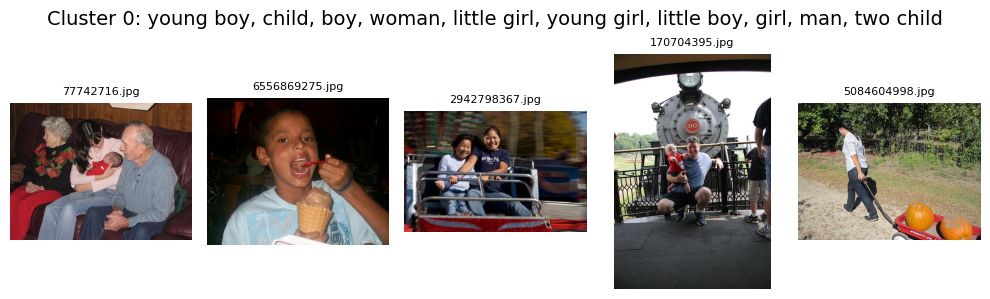

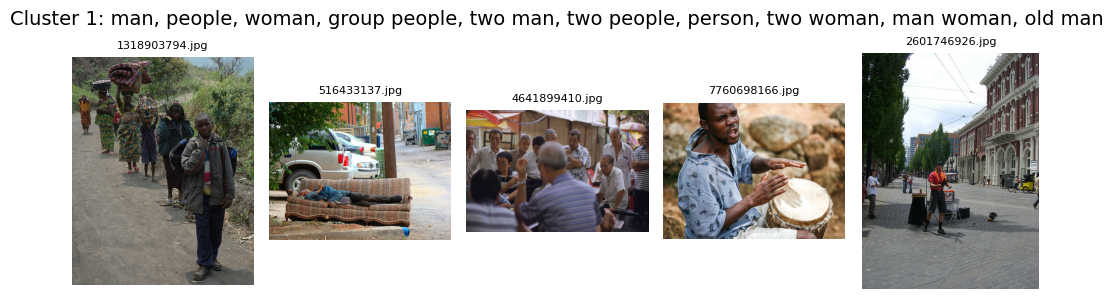

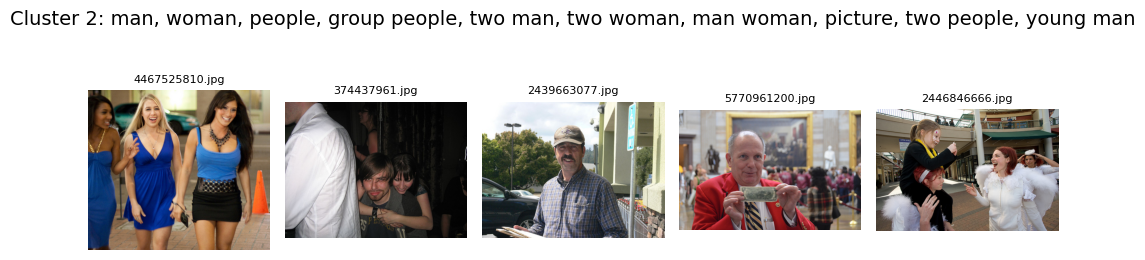

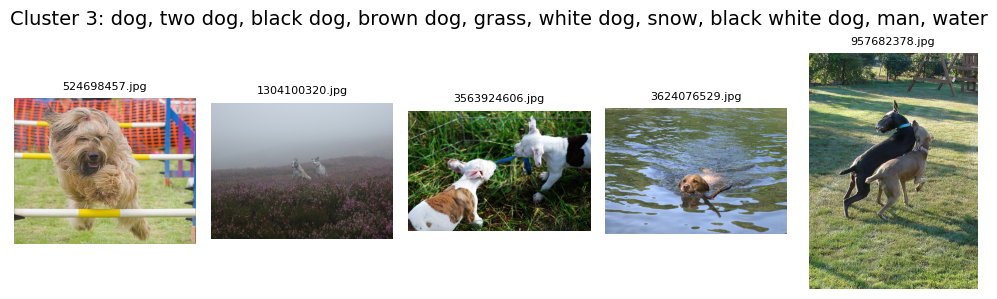

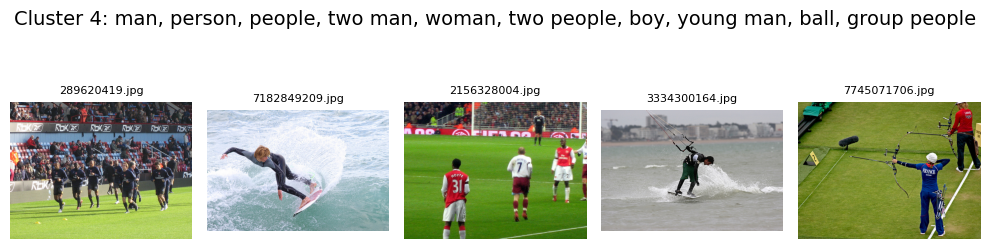

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def mostrar_imagenes_por_cluster(df, cluster_labels, image_dir, num_img=5, figsize=(10, 3)):
    """
    Visualiza imágenes representativas por cluster con etiquetas.
    
    df: DataFrame que contiene las columnas 'imagen' y 'cluster'
    cluster_labels: dict con etiquetas por cluster
    image_dir: ruta a las imágenes
    num_img: cuántas imágenes mostrar por cluster
    """
    clusters = sorted(df['cluster'].unique())

    for cluster_id in clusters:
        cluster_df = df[df['cluster'] == cluster_id]
        muestra = cluster_df.sample(n=min(num_img, len(cluster_df)), random_state=42)

        fig, axes = plt.subplots(1, len(muestra), figsize=figsize)
        if len(muestra) == 1:
            axes = [axes]  # para evitar error si hay solo una imagen

        fig.suptitle(f"Cluster {cluster_id}: {cluster_labels[cluster_id]}", fontsize=14)

        for ax, (_, row) in zip(axes, muestra.iterrows()):
            img_path = os.path.join(image_dir, row["imagen"])
            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                ax.imshow(img)
                ax.set_title(os.path.basename(row["imagen"]), fontsize=8)
            else:
                ax.text(0.5, 0.5, 'Imagen no encontrada', ha='center', va='center')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

mostrar_imagenes_por_cluster(
    grouped,
    cluster_labels,
    images_dir,
    num_img=5,
    figsize=(10, 3)
)

### Clusterizar nuevas imagenes sin descripciones


In [150]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Cargar imagen y preprocesar
image = preprocess(Image.open("test_images/perro.jpeg")).unsqueeze(0).to(device)

# Obtener embedding visual
with torch.no_grad():
    image_embedding = model.encode_image(image)

# Embedding de texto vacío, tensor PyTorch
empty_text_embedding = torch.zeros((1, 512), device=device)


# Concatenar tensores en la dimensión de características
example_fused_embedding = torch.cat([image_embedding, empty_text_embedding], dim=1)  # shape (1, 1024)

# Convertir a numpy para sklearn
example_fused_embedding_np = example_fused_embedding.cpu().numpy()

# Predict con kmeans
cluster_id = kmeans.predict(example_fused_embedding_np)[0]
print(f"Cluster asignado: {cluster_id}")

Cluster asignado: 3


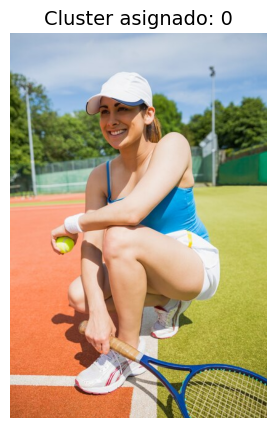

In [41]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Cargar imagen y preprocesar
imagen_path = "test_images/tenista.jpg"
original_imagen = Image.open(imagen_path)
image = preprocess(original_imagen).unsqueeze(0).to(device)

# Obtener embedding visual
with torch.no_grad():
    image_embedding = model.encode_image(image)

# Embedding de texto vacío, tensor PyTorch
empty_text_embedding = torch.zeros((1, 512), device=device)


# Concatenar tensores en la dimensión de características
example_fused_embedding = torch.cat([image_embedding, empty_text_embedding], dim=1)  # shape (1, 1024)

# Convertir a numpy para sklearn
example_fused_embedding_np = example_fused_embedding.cpu().numpy()

# Predict con kmeans
cluster_id = kmeans.predict(example_fused_embedding_np)[0]
plt.figure(figsize=(5, 5))
plt.imshow(original_imagen)
plt.axis('off')
plt.title(f"Cluster asignado: {cluster_id}", fontsize=14)
plt.show()

Como podemos ver, las carácteristicas textuales aportan un gran valor a este modelo multimodal y sin la parte textual se pierde un contexto importante, vamos a probarlo si fuera al contrario, el caso en el que tenemos únicamente las descripciones.


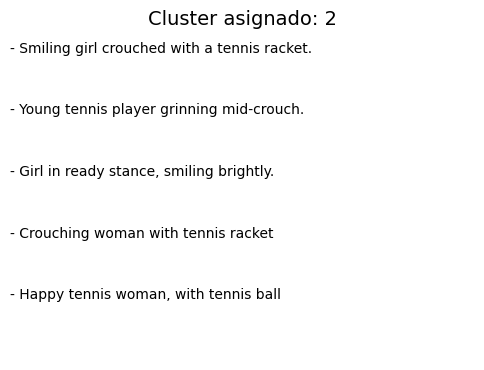

In [63]:
# texts = [
#     "A dog is playing in the park.",
#     "A happy dog running through the grass.",
#     "A playful dog catching a ball outdoors.",
#     "A brown dog jumping around the playground.",
#     "A dog enjoying a sunny day in the park."
# ]
texts = ["Smiling girl crouched with a tennis racket.",
         "Young tennis player grinning mid-crouch.",
         "Girl in ready stance, smiling brightly.",
         "Crouching woman with tennis racket",
         "Happy tennis woman, with tennis ball"]

text_tokens = clip.tokenize(texts).to(device)  # (5, max_len)

with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)  # (5, 512)

# Promediamos para obtener un solo embedding representativo del conjunto
mean_text_embedding = text_embeddings.mean(dim=0, keepdim=True)  # (1, 512)

# Creamos vector de ceros para la parte imagen (sin imagen)
empty_image_embedding = torch.zeros((1, 512), device=device)  # (1, 512)

# Concatenamos (imagen + texto)
example_fused_embedding = torch.cat([empty_image_embedding, mean_text_embedding], dim=1)  # (1, 1024)

# Convertimos a numpy para sklearn
example_fused_embedding_np = example_fused_embedding.cpu().numpy()

# Predecimos cluster
cluster_id = kmeans.predict(example_fused_embedding_np)[0]
plt.figure(figsize=(6, 4))
plt.axis('off')
plt.title(f"Cluster asignado: {cluster_id}", fontsize=14, pad=20)
for i, text in enumerate(texts):
    plt.text(0, 1 - i*0.2, f"- {text}", fontsize=10, wrap=True)

plt.show()


En este caso, parece que la clusterización es adecuada ya que se junta con el cluster que describe mascotas.

Vamos finalmente a probar con un caso que incorpora las dos características, visual y textual.

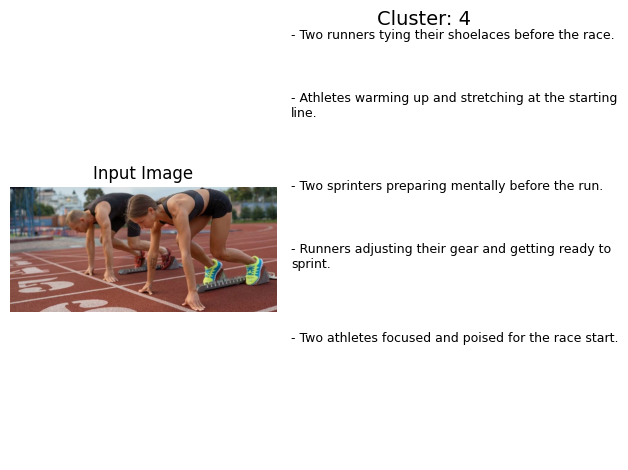

In [55]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Cargar y preprocesar imagen
imagen_path = "test_images/atletas.jpg"
image = Image.open(imagen_path)
image_tensor = preprocess(image).unsqueeze(0).to(device)

# Procesar imagen
with torch.no_grad():
    image_embedding = model.encode_image(image_tensor)  # (1, 512)

# Procesar texto
texts = [
    "Two runners tying their shoelaces before the race.",
    "Athletes warming up and stretching at the starting line.",
    "Two sprinters preparing mentally before the run.",
    "Runners adjusting their gear and getting ready to sprint.",
    "Two athletes focused and poised for the race start."
]

text_tokens = clip.tokenize(texts).to(device)

with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)  # (5, 512)

# Promediar embeddings de texto para obtener representación única
mean_text_embedding = text_embeddings.mean(dim=0, keepdim=True)  # (1, 512)

# Concatenar imagen + texto
fused_embedding = torch.cat([image_embedding, mean_text_embedding], dim=1)  # (1, 1024)

# Convertir a numpy para kmeans
fused_embedding_np = fused_embedding.cpu().numpy()

# Predecir cluster
cluster_id = kmeans.predict(fused_embedding_np)[0]
# Imagen
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")

# Textos y cluster
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title(f"Cluster: {cluster_id}", fontsize=14, pad=10)
for i, text in enumerate(texts):
    plt.text(0, 1 - i*0.18, f"- {text}", fontsize=9, wrap=True, transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()
